In [1]:
%matplotlib inline
import qutip as qt
import numpy as np
import scipy
from scipy import constants
import itertools
import math

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from systemConst import Tunabletransmon,QQ,iniState1Qsys,iniState2Qsys
from CZwave3 import CZpulse

pi = np.pi
e = constants.e
h = constants.h
hbar = constants.hbar
ep0 = constants.epsilon_0
mu0 = constants.mu_0
opts = qt.solver.Options(nsteps=10000)

In [2]:
#savepath = 'C:/Sota_Ino/Scripts/TestKankyo/cQEDSim/core/' #PC in TUS
savepath = 'C:/Users/Sota/Scripts/TestKankyo/cQEDSim/core/'

In [3]:
filterpath=savepath+'fir_coe.npy'
FIRfilter = np.load(savepath+'fir_coe.npy')

In [4]:
####### Hamiltonian term generators #######
def ket(Nq, i):
    return qt.basis(Nq, i)

def jj(Nq, lv):
    ket = qt.basis(Nq, lv)
    return ket * ket.dag()

def Delta_q(wqs:list, wd, j):
    return wqs[j] - j * wd

def Hq(Nq, wqs:list):
    Hqs = 0
    for i in range(Nq):
        Hqs = Hqs + wqs[i] * jj(Nq, i)
    return Hqs
    
def Hq_rot(Nq, wqs:list, wd):
    Hqr = 0
    for i in range(Nq):
        D = Delta_q(wqs, wd, i)
        Hqr = Hqr + D * jj(Nq, i)
    return Hqr

def _jj1(Nq, i):
    # for taransmon's destroy operator
    ket_low = qt.basis(Nq, i)
    bra_high = qt.basis(Nq, i+1).dag()
    return ket_low * bra_high

def c(Nq):
    # taransmon's destroy operator
    cc = 0
    for i in range(Nq-1):
        cc = cc + np.sqrt(i + 1) * _jj1(Nq, i)
    return cc

######### N-level paulis #########
def pI_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() + ket(Nq, 1) * ket(Nq, 1).dag()

def pX_N(Nq):
    return ket(Nq, 0) * ket(Nq, 1).dag() + ket(Nq, 1) * ket(Nq, 0).dag()

def pY_N(Nq):
    return 1j*ket(Nq, 0) * ket(Nq, 1).dag() - 1j*ket(Nq, 1) * ket(Nq, 0).dag()

def pZ_N(Nq):
    return ket(Nq, 0) * ket(Nq, 0).dag() - ket(Nq, 1) * ket(Nq, 1).dag()

######### N-level Single qubit rotation #########
def RX(theta, Nq, Nf):
    x = pX_N(Nq) * (-1j*theta/2)
    return qt.tensor(x.expm(), qt.qeye(Nf))

def RY(theta, Nq, Nf):
    y = pY_N(Nq) * (-1j*theta/2)
    return qt.tensor(y.expm(), qt.qeye(Nf))

def RZ(theta, Nq, Nf):
    z = pZ_N(Nq) * (-1j*theta/2)
    return qt.tensor(z.expm(), qt.qeye(Nf))

####### Plot utility functions #######
def evals(ini_state, props, e_ops):
    # 与えられた演算子に対する期待値のリストを返す
    
    # 例 
    # input : e_ops = [A, B, C] -> output : [[A-evals], [B-evals], [C-evals]] 
    
    # ini_stateは密度行列で渡す
    # propsは超演算子として渡す
    # e_opsはリストで渡す
    es = []
    for i in range(len(e_ops)):
        ee = []
        for j in range(len(props)):
            r = props[j] * qt.operator_to_vector(ini_state)
            rr = qt.vector_to_operator(r)
            e = qt.expect(e_ops[i], rr).real #qt.expect(ope,state)で期待値
            ee.append(e)
        es.append(ee)
    return es

def bloch(evals):
    # ブロッホ球を描画するだけ
    b = qt.Bloch()
    
    b.add_vectors([evals[0][0], evals[1][0], evals[2][0]])
    b.add_vectors([evals[0][-1], evals[1][-1], evals[2][-1]])
    b.add_points(evals, meth='l')
    b.make_sphere()

    b.show()

    
######## Calc. Propagator ######## ( wrapper of qutip.propagator() )
def simple_prop(H, t_list, c_ops, p_args, mode, steps=10000):
    # 散逸がある場合とない場合でqt.propagatorの返す形式が異なるので、その違いを吸収する。
    # どちらの場合も超演算子形式で返すようにする。
    if mode == 'sch':
        _res = qt.propagator(H, t_list, c_ops=[], args=p_args, parallel=False, options=qt.Options(nsteps=steps))
        res = []
        for i in range(len(_res)):
            sp = qt.to_super(_res[i])
            res.append(sp)
        res = np.array(res)
    elif mode == 'lind':
        res = qt.propagator(H, t_list, c_ops, args=p_args, parallel=False, options=qt.Options(nsteps=steps))
    
    return res

## Fidelity utility
---
Ref : [Direct Fidelity Estimation from Few Pauli Measurements](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.230501)

\begin{align}
    d &= 2^n, n : qubits \\
    \mathcal{U} &: ideal\,channel,\;\; \mathcal{E} : exp.\,channel \\
    \chi_\mathcal{U}(k, k') &= \frac{1}{d}\mathrm{Tr}[W_k \mathcal{U}(W_k')] \\
    X &= \chi_\mathcal{E}(k, k') / \chi_\mathcal{U}(k, k') \\
    Pr(k,k') &= \frac{1}{d^2}\left[ \chi_\mathcal{U}(k, k') \right]^2 \\
    F_e &= {\mathrm{Tr}[\mathcal{U}^\dagger \mathcal{E}]}{d^2} \\
    F_e &= expe.X = \sum_{k, k'}X_{k, k'} Pr(k,k')\\
    F_{avg} &= \frac{d*F_e+1}{d+1}
\end{align}

In [5]:
def paulis_set(Nq, n):
    pauli = [pI_N(Nq), pX_N(Nq), pY_N(Nq), pZ_N(Nq)]
    p_list = list(itertools.product(pauli, repeat=n))      
    W_set = []
    for k in range(len(p_list)):
        ps = p_list[k]
        w = ps[0]
        for l in range(1, len(ps)):
            w = qt.tensor(w, ps[l])
        W_set.append(w)
    return W_set

#print(len(paulis_set(3,2))) =16

# for Two qubit gates
def _tr(Ope, p, q, paulis, Nq, n):
    
    Wp = paulis[p]
    Wq = paulis[q]
    Wq_vec = qt.operator_to_vector(Wq)
    b = (Ope * Wq_vec)
    c = qt.vector_to_operator(b)
    a = Wp * c
    mat = a.full()
    return a.tr()

def agf(Ope, target, Nq, n):
    
    d = 2**n
    paulis = paulis_set(Nq, n)
    eX = []
    P = []
    for p in range(len(paulis)):
        for q in range(len(paulis)):
            e = _tr(Ope, p, q, paulis, Nq, n)/d
            u = _tr(target, p, q, paulis, Nq, n)/d
            prb = (1/(d**2)) * u**2
            P.append(prb)
            if u != 0:
                eX.append((e/u)*prb)
            else:
                eX.append(0)
    Fe = np.sum(eX)
    Fave = (d * Fe+1)/(d+1)
    return Fave, Fe, np.sum(P)

## Pulse shape
---

In [6]:
def square(Tg, scale=1):
    return np.ones(Tg) * scale
"""
def MW_shaped(t,args):
    
    amp = args['mwamp']
    shape = args['shape'] 
    steps = args['steps']

    if int(t*steps)>=len(shape):
        n=len(shape)-1
    else:
        n=int(t*steps)

    return amp * shape[n]
"""

"\ndef MW_shaped(t,args):\n    \n    amp = args['mwamp']\n    shape = args['shape'] \n    steps = args['steps']\n\n    if int(t*steps)>=len(shape):\n        n=len(shape)-1\n    else:\n        n=int(t*steps)\n\n    return amp * shape[n]\n"

In [7]:
def MW_shaped1(t,args):
    
    amp1 = args['mwamp1']
    shape1 = args['shape1'] 
    steps1 = args['steps1']

    if int(t*steps1)>=len(shape1):
        n=len(shape1)-1
    else:
        n=int(t*steps1)

    return amp1 * shape1[n]
    
def MW_shaped2(t,args):
    
    amp2 = args['mwamp2']
    shape2 = args['shape2'] 
    steps2 = args['steps2']

    if int(t*steps2)>=len(shape2):
        n=len(shape2)-1
    else:
        n=int(t*steps2)

    return amp2 * shape2[n]

## Parameters
---

In [8]:
###### qubit [GHz] ######
Nq = 3
Q1 = Tunabletransmon(f01=5.286,alpha=-0.318,Nq=3)
Q2 = Tunabletransmon(f01=5.759,alpha=-0.298,Nq=3)
wq1s=Q1.enes
wq2s=Q2.enes
fq1=wq1s[1]
fq2=wq2s[1]

J=0.015 #[GHz]
QQ=QQ(Q1,Q2,J)
print(fq1+abs(Q2.anh))

5.584


## Hamiltonian assembling
---

In [9]:
i = qt.qeye(2)
x = qt.sigmax()
y = qt.sigmay()
z = qt.sigmaz()
sp = qt.sigmap()
sm = qt.sigmam()

Iq1 = qt.qeye(Nq)
Iq2 = qt.qeye(Nq)
####### effective N-level pauli #######
pI = pI_N(Nq)
px = pX_N(Nq)
py = pY_N(Nq)
pz = pZ_N(Nq)

X1 = qt.tensor(px, Iq2)
Y1 = qt.tensor(py, Iq2)
Z1 = qt.tensor(pz, Iq2)
e_ops = [X1, Y1, Z1]

In [10]:
###### Assembling Lab frame Hamiltonian ######
# 2qubit-labframe
c1 = c(Nq)
C1 = qt.tensor(c1, Iq2)
c2 = c(Nq)
C2 = qt.tensor(Iq1,c2)

Hq1_lab = qt.tensor(Hq_rot(Nq, wq1s, 0), Iq2)
Hq2_lab = qt.tensor(Iq1,Hq_rot(Nq, wq2s, 0))
Hint = QQ.Hint12*(2*pi)
Hlab = Hq1_lab + Hq2_lab + Hint

#2qubit-rotatingframe
#Hq1_rot = Hq1_lab
Hq1_rot = qt.tensor(Hq_rot(Nq, wq1s, fq1), Iq2)*(2*pi)
rot1 = Hq_rot(Nq,[0,0,Q1.anh*(2*pi)],fq1*(2*pi))

Hq2_rot = qt.tensor(Iq1,Hq_rot(Nq, wq2s, fq2))*(2*pi)
rot2 = Hq_rot(Nq,[0,0,Q2.anh*(2*pi)],fq2*(2*pi))

q1Freqs = qt.qdiags(np.arange(0,Q1.Nq,1),0)
Hq1_t_ind = qt.tensor(rot1, Iq2) #Hq2_rot(constant term)
Hq1_t_dep = qt.tensor(q1Freqs,Iq2) #Hq2_rot(modulation term)

q2Freqs = qt.qdiags(np.arange(0,Q2.Nq,1),0)
Hq2_t_ind = qt.tensor(Iq1, rot2) #Hq2_rot(constant term)
Hq2_t_dep = qt.tensor(Iq1, q2Freqs) #Hq2_rot(modulation term)

H_rot = [Hq1_t_ind + Hq2_t_ind + Hint, [Hq1_t_dep,MW_shaped1],[Hq2_t_dep, MW_shaped2]]

In [24]:
#最近接バイアス
Q1_m_I1 = -2.14 #Q1側のI1の下端
Q1_p_I1 = 2.44  #Q1側のI1の上端
Q2_m_I2 = -1.22 #Q2側のI2の下端
Q2_p_I2 = 1.43  #Q2側のI2の上端

#クロストーク
Q1_m_I2 = -3.06
Q1_p_I2 = 3.54
Q2_m_I1 = -2.989
Q2_p_I1 = 3.693

pifluxquanta_1 = Q1_p_I1-Q1_m_I1
pifluxquanta_2 = Q2_p_I2-Q2_m_I2
m11 = pi/pifluxquanta_1
m22 = pi/pifluxquanta_2
currentoffset1 = (Q1_p_I1+Q1_m_I1)/2
currentoffset2 = (Q2_p_I2+Q2_m_I2)/2

print('πΦ_1={:.2f}[mA]'.format(pifluxquanta_1))
print('πΦ_2={:.2f}[mA]'.format(pifluxquanta_2))
print('m11:{:.3f}[Φ/mA]'.format(m11))
print('m22:{:.3f}[Φ/mA]'.format(m22))
print('currentoffset1={:.3f}[mA]'.format(currentoffset1))
print('currentoffset2={:.3f}[mA]'.format(currentoffset2))

pifluxquanta_1_2 = Q1_p_I2-Q1_m_I2
pifluxquanta_2_1 = Q2_p_I1-Q2_m_I1
m12 = pi/pifluxquanta_1_2
m21 = pi/pifluxquanta_2_1
currentoffset12 = (Q1_p_I1+Q1_m_I1)/2
currentoffset21 = (Q2_p_I2+Q2_m_I2)/2

print('πΦ_12={:.2f}[mA]'.format(pifluxquanta_1_2))
print('πΦ_21={:.2f}[mA]'.format(pifluxquanta_2_1))
print('m11:{:.3f}[Φ/mA]'.format(m11))
print('m22:{:.3f}[Φ/mA]'.format(m22))
print('currentoffset1={:.3f}[mA]'.format(currentoffset1))
print('currentoffset2={:.3f}[mA]'.format(currentoffset2))

πΦ_1=4.58[mA]
πΦ_2=2.65[mA]
m11:0.686[Φ/mA]
m22:1.186[Φ/mA]
currentoffset1=0.150
currentoffset2=0.105


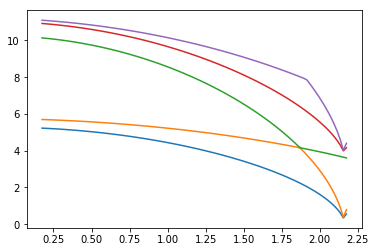

In [26]:
#currentに対する感受性を調べる
keys={0:['00','b'],1:['10','y'],2:['01','r'],3:['20','k'],4:['11','m'],5:['02','c'],6:['12','#a65628'],7:['21','#ff7f00']}
enemap=np.zeros((Nq**2,len(current)))

iq1, iq2 = qt.qeye(3), qt.qeye(3)
b1, b2 = qt.destroy(3), qt.destroy(3)
B1 = qt.tensor(b1, iq2)
B2 = qt.tensor(iq1, b2)
Hq1 = Q1.Hqlab
J=0.05
Hint = J*(B1*B2.dag() + B1.dag()*B2)
Q1ini=Tunabletransmon(f01=5.284,alpha=-0.318,Nq=3,phi=0)
Q2ini=Tunabletransmon(f01=5.759,alpha=-0.298,Nq=3,phi=0)

# Q1側のバイアスのみ動かす
for k,cur in enumerate(current):
    mag1 = 0.686/pi*cur+fluxoffset1
    mag2 = 0.470/pi*cur+fluxoffset2
    Q1 = Tunabletransmon(f01=5.284,alpha=-0.318,Nq=3,phi=mag1)
    Q2 = Tunabletransmon(f01=5.759,alpha=-0.298,Nq=3,phi=mag2)
    Hq1 = qt.tensor(Q1.Hqlab,iq2)
    Hq2 = qt.tensor(iq1,Q2.Hqlab)
    QQHam=Hq1 + Hq2 + Hint
    ene=np.array([QQHam.eigenenergies()])
    enes=[ene[0][i] - ene[0][0] for i in range(len(ene[0]))]
    for count in range(0,Nq**2):
        enemap[count][k]=enes[count]

plt.figure()
for count2 in range(0,Nq**2-1):
    #if keys[count2][0] in ['20','11','02']:
    if keys[count2][0] in ['10','01','11','02','20']:
        plt.plot(current,enemap[count2],label=keys[count2][0])
plt.savefig('C:/Users/Sota/Scripts/TestKankyo/cQEDSim/core/bias1_level.png')

-0.17999999999999994


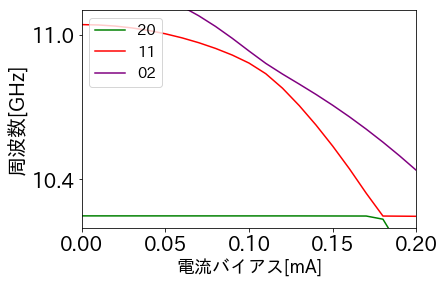

In [47]:
import japanize_matplotlib

currentoffset2 = 1.175 #[mA]
current=np.linspace(currentoffset2-1,currentoffset2+1,101)
current = np.linspace(-0.7,0.7,141)
enemap=np.zeros((Nq**2,len(current)))

Q1 = Tunabletransmon(f01=5.284,alpha=-0.318,Nq=3,phi=0)
# Q2側のバイアスのみ動かす
for k,cur in enumerate(current):
    #mag1 = 0.476/pi*cur+fluxoffset1
    mag1 = 0
    mag2 = cur #1.186/pi*(cur-currentoffset2)
    Q2 = Tunabletransmon(f01=5.759,alpha=-0.298,Nq=3,phi=mag2)
    Hq1 = Q1.f01 * Nb1 + duff_part1
    Hq2 = Q2.f01 * Nb2 + duff_part2 #  - self.Iq2*0
    QQHam=Hq1 + Hq2 + Hint
    ene=np.array([QQHam.eigenenergies()])
    enes=[ene[0][i] - ene[0][0] for i in range(len(ene[0]))]
    for count in range(0,Nq**2):
        enemap[count][k]=enes[count]
            
plt.figure()
for count2 in range(0,Nq**2-1):
    if keys[count2][0]=='20':
        plt.plot(current,enemap[count2],label=keys[count2][0],color='g')
    if keys[count2][0]=='11':
        plt.plot(current,enemap[count2],label=keys[count2][0],color='red')
    if keys[count2][0]=='02':
        plt.plot(current,enemap[count2],label=keys[count2][0],color='purple')

ene_sa = np.abs(ene10-ene01)
curr = current[np.argmin(ene_sa)]
print(curr)
#plt.vlines(curr,0,10)
plt.xlim([0.0,0.2])
plt.ylim([10.2,11.1])
plt.xlabel('電流バイアス[mA]',fontsize=18)
plt.ylabel('周波数[GHz]',fontsize=20)
plt.legend(loc='upper left',fontsize=15)
plt.yticks([10.4, 11],fontsize=20)
plt.xticks([0.0,0.05, 0.10, 0.15, 0.20],fontsize=20)
plt.yticks(fontsize=20)
plt.savefig('C:/Users/Sota/Scripts/TestKankyo/cQEDSim/core/bias2_level.png')

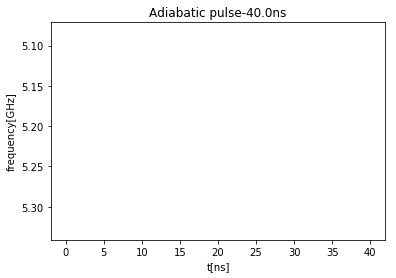

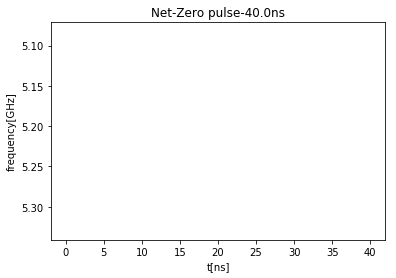

In [30]:
Tg_standard = int(1/(2*np.sqrt(2)*J))
Tg=40
step=1
mwamp = 2*pi

pulsesystem1=CZpulse(Q1,Q2,J,the_f=0.925,lambda2=0.0725,tg=Tg,steps=step)
qFreq20 = pulsesystem1.qFreq20

pulsesystem2=CZpulse(Q1,Q2,J,the_f=0.925,lambda2=0.0725,tg=Tg,steps=step)

t_list1,adi=pulsesystem1.flux_to_pulse(offset=0.000,pulsetype='Adiabatic',PLOT=True)
t_list2,net=pulsesystem2.flux_to_pulse(offset=0.000,pulsetype='Net-Zero',PLOT=True)

stable = fq1*np.ones(len(net))
#t_listt,adicurrent=pulsesystem1.adiabaticcurrent(offset=0.00,PLOT=True)
#t_list2,nzcurrent=pulsesystem1.netzerocurrent(offset=0.01,PLOT=True)
#t_list3,nzpulse=pulsesystem.flux_to_pulse(offset=0.001,pulsetype='Net-Zero',PLOT=True)

args_adi = {'mwamp':mwamp, 'shape':adi, 'steps':step}
args_net = {'mwamp':mwamp, 'shape':net, 'steps':step}

args_2bias={'mwamp1':mwamp, 'shape1':net, 'steps1':step,'mwamp2':mwamp, 'shape2':stable, 'steps2':step}

In [15]:
def squarepulse(Tg,t_ini,t_ramp,PLOT=False):
    t_list = np.linspace(0,Tg,Tg+1)
    shape = []
    
    for t in t_list:
        if t < t_ini:
            a = 0
        elif t <= t_ini + t_ramp:
            a = 1/ t_ramp*(t-t_ini)
        elif t > Tg - (t_ini):
            a = 0
        elif t >= Tg - (t_ramp+t_ini):
            a = 1 - 1/ t_ramp*(Tg-(t+t_ini))
        else:
            a = 1
        shape.append(round(a,5))
        
    return t_list,shape

In [16]:
def inversefiltered_pulse(pulse,loadpath=None,PLOT=False,savepath=None): #Zhouさんのメソッドを用いて補正していく予定
    if loadpath is None:
        FIRfilter=np.load('C:/Sota_Ino/Tsai_Lab/fir_coe.npy')
    else:
        FIRfilter=np.load(loadpath)
        
    fs=len(pulse)
    t = np.arange(0,fs)
    print(len(t),len(d))
    d = np.zeros(fs)
    b = self.FIRfilter
    for i in range(fs):
        d[i] = 0
        for j in range(len(b)):
            if(i-j)>=0:
                d[i] += b[j]*x[i-j]
    
    if PLOT is True:
        plt.figure()
        plt.plot(t,pulse)
        plt.plot(t,d)
        plt.show()
        if savepath is not None:
            plt.savefig(savepath)
        else:
            pass
    
    Filteredcurrent=d

    return Filteredcurrent

In [ ]:
pulse = squarepule

In [12]:
ini_state=qt.tensor(iniState1Qsys(Nq,1,'rho'),(px+pI)/2)

In [13]:
qproj = qt.qdiags([1 if i<2 else 0 for i in range(Nq)],0)
proj=qt.tensor(qproj,qproj)

# target Operator
onestate=iniState1Qsys(3,1,'rho')
cz=proj-2*qt.tensor(onestate,onestate)

In [14]:
res1 = qt.propagator(H_rot, t_list1,[],args=args_2bias, parallel=False, options=qt.Options(nsteps=10000))
prop_fin1=proj.dag()*res1[-1]*proj
prop_fin1

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.94746241+0.31942781j  0.        +0.j
  -0.01238619+0.01128932j  0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.01239519+0.01127926j  0.        +0.j
   0.22968677+0.9731203j   0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.    

In [15]:
res2 = qt.propagator(H_rot, t_list2,[],args2, parallel=False, options=qt.Options(nsteps=10000))
prop_fin2=proj.dag()*res2[-1]*proj
prop_fin2

NameError: name 'args2' is not defined

## Fidelity

In [14]:
target = qt.to_super(cz)
Fave, Fe, prb = agf(qt.to_super(prop_fin1), target, Nq, 2)
print('Fave = '+'{:.2f}'.format(Fave*100))

Fave = 59.79


In [15]:
Fave, Fe, prb = agf(qt.to_super(prop_fin2), target, Nq, 2)
print('Fave = '+'{:.2f}'.format(Fave*100))

Fave = 73.59+0.00j


In [16]:
mat1=prop_fin1.full()
phase01=np.angle(mat1[1][1])
phase10=np.angle(mat1[3][3])
phase11=np.angle(mat1[4][4])
conditional_phase=(phase11-phase01-phase10)/pi
print('phase01:{:.3f}'.format(phase01))
print('phase10:{:.3f}'.format(phase10))
print('phase11:{:.3f}'.format(phase11))
print('conditional_phase:{:.3f}pi'.format(conditional_phase))

phase01:3.106
phase10:0.170
phase11:0.138
conditional_phase:-0.999pi


In [17]:
mat2=prop_fin2.full()
phase01=np.angle(mat2[1][1])
phase10=np.angle(mat2[3][3])
phase11=np.angle(mat2[4][4])
conditional_phase=(phase11-phase01-phase10)/pi
print('phase01:{:.3f}'.format(phase01))
print('phase10:{:.3f}'.format(phase10))
print('phase11:{:.3f}'.format(phase11))
print('conditional_phase:{:.3f}pi'.format(conditional_phase))

phase01:2.520
phase10:0.170
phase11:0.267
conditional_phase:-0.771pi


## Behavior of One Qubit State

In [29]:
r1=_res.states[-1].ptrace(0)
r1

NameError: name '_res' is not defined

In [64]:
r2=_res.states[-1].ptrace(1)
r2

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.49955923+0.j         0.37293016+0.31248977j 0.        +0.j        ]
 [0.37293016-0.31248977j 0.47425434+0.j         0.00157022-0.00327401j]
 [0.        +0.j         0.00157022+0.00327401j 0.02618643+0.j        ]]

In [65]:
q1_evals=[]
q2_evals=[]
for state in _res.states:
    rho1=state.ptrace(0)
    _evals1=[qt.expect(px, rho1).real,qt.expect(py, rho1).real,qt.expect(pz, rho1).real]
    q1_evals.append(_evals1)
    rho2=state.ptrace(1)
    _evals2=[qt.expect(px, rho2).real,qt.expect(py, rho2).real,qt.expect(pz, rho2).real]
    q2_evals.append(_evals2)

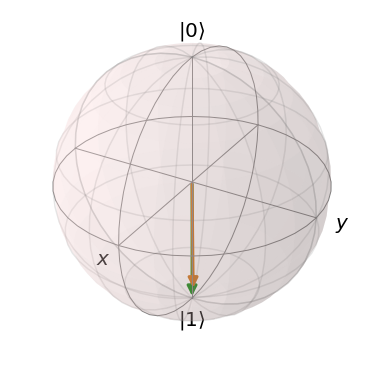

In [66]:
b1 = qt.Bloch()
b1.add_vectors([q1_evals[0][0], q1_evals[0][1], q1_evals[0][2]])
b1.add_vectors([q1_evals[-1][0], q1_evals[-1][1], q1_evals[-1][2]])
b1.show()

0.7458603202704887 0.6249795493168355 0.025304888918896373


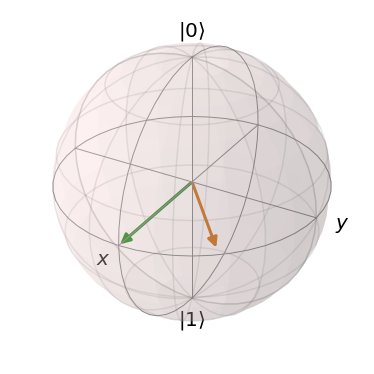

In [67]:
b2 = qt.Bloch()
b2.add_vectors([q2_evals[0][0], q2_evals[0][1], q2_evals[0][2]])
b2.add_vectors([q2_evals[-1][0], q2_evals[-1][1], q2_evals[-1][2]])
print(q2_evals[-1][0], q2_evals[-1][1], q2_evals[-1][2])
b2.show()